In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display, clear_output
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

Hyperparameters

In [ ]:
CSV_PATH = '/content/sample_data/2025-grievances.csv'   # adjust if needed
USE_COLUMNS = ['Sub Category', 'Grievance Date']
SEQUENCE_LENGTH = 30          # days of history required
MIN_SAMPLES = 80              # minimal number of sequence samples required to train
TF_RANDOM_SEED = 42
np.random.seed(0)
tf.random.set_seed(TF_RANDOM_SEED)

In [ ]:
#Load data
df = pd.read_csv(CSV_PATH, usecols=USE_COLUMNS)
df['Grievance Date'] = pd.to_datetime(df['Grievance Date'])

# Build dynamic problem types from CSV (do not hardcode)
problem_types = [
    'Street Light Not Working', 'Garbage dumping in vacant sites', 'Potholes',
    'Garbage dump', 'Others', 'water stagnation', 'Cleanliness'
]
if not problem_types:
    raise RuntimeError("No 'Sub Category' values found in the CSV.")

In [ ]:
category_dropdown = widgets.Dropdown(
    options=problem_types,
    value=problem_types[0],
    description='Problem:',
    style={'description_width': 'initial'}
)
date_picker = widgets.DatePicker(description='Start Date')
days_slider = widgets.IntSlider(
    value=30, min=1, max=60, step=1, description='Days Ahead'
)
predict_button = widgets.Button(description="🔮 Predict", button_style='success')
progress = widgets.IntProgress(value=0, min=0, max=100, description='Progress:', bar_style='info')
output_area = widgets.Output()

ui = widgets.VBox([
    widgets.HBox([category_dropdown, date_picker, days_slider, predict_button]),
    progress,
    output_area
])

In [ ]:
def issue_forecast(selected_problem, sel_date):
    progress.value = 10
    mask = df['Sub Category'] == selected_problem
    df_sub = df[mask].copy()

    # Build daily time series
    daily = df_sub.groupby(df_sub["Grievance Date"].dt.date).size().reset_index(name='count')
    daily['date'] = pd.to_datetime(daily['Grievance Date'])
    daily = daily[['date', 'count']]
    if daily.empty:
        print(f"No data available for {selected_problem}.")
        return
    full_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
    daily = daily.set_index('date').reindex(full_range, fill_value=0).rename_axis('date').reset_index()

    # Features
    daily['month'] = daily['date'].dt.month
    daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
    daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)
    daily['dayofweek'] = daily['date'].dt.dayofweek
    daily['dow_sin'] = np.sin(2 * np.pi * daily['dayofweek'] / 7)
    daily['dow_cos'] = np.cos(2 * np.pi * daily['dayofweek'] / 7)
    festival_dates = ['2025-03-29', '2025-04-12', '2025-05-16']
    daily['is_festival'] = daily['date'].astype(str).isin(festival_dates).astype(int)
    holiday_dates = [
        '2025-01-01','2025-01-14','2025-01-26','2025-03-29','2025-04-12',
        '2025-05-01','2025-08-15','2025-10-02','2025-11-01','2025-12-25'
    ]
    daily['is_holiday'] = daily['date'].astype(str).isin(holiday_dates).astype(int)
    np.random.seed(0)
    daily['rain_mm'] = np.random.gamma(3, 4, size=len(daily))
    daily['count_lag1'] = daily['count'].shift(1).fillna(0)
    daily['count_lag2'] = daily['count'].shift(2).fillna(0)
    daily['log_count'] = np.log1p(daily['count'])
    daily['count_lag7'] = daily['count'].shift(7).fillna(0)
    daily['count_rolling_max7'] = daily['count'].rolling(7, min_periods=1).max().shift(1).fillna(0)
    daily['count_rolling_sum7'] = daily['count'].rolling(7, min_periods=1).sum().shift(1).fillna(0)

    features = [
        'count', 'count_lag1', 'count_lag2', 'count_lag7',
        'count_rolling_max7', 'count_rolling_sum7',
        'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
        'is_festival', 'is_holiday', 'rain_mm'
    ]
    X_all = daily[features].values.astype(float)
    y_all = daily['log_count'].values.astype(float)

    # Sequences
    def create_sequences(X, y, seq_len):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_len):
            X_seq.append(X[i:i+seq_len])
            y_seq.append(y[i+seq_len])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(X_all, y_all, SEQUENCE_LENGTH)
    if len(X_seq) < MIN_SAMPLES:
        print(f"Not enough data for {selected_problem} ({len(X_seq)} samples).")
        return

    split = int(0.8*len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    f_scaler = MinMaxScaler()
    X_train_scaled = f_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_test_scaled = f_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

    t_scaler = MinMaxScaler()
    y_train_scaled = t_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
    y_test_scaled = t_scaler.transform(y_test.reshape(-1,1)).flatten()

    # Model
    progress.value = 40
    tf.random.set_seed(TF_RANDOM_SEED)
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.12),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_scaled, epochs=60, batch_size=8,
              validation_data=(X_test_scaled, y_test_scaled), callbacks=[es], verbose=0)

    # Forecast horizon = days until selected date
    sel_date = pd.to_datetime(sel_date)
    start_date = daily['date'].iloc[-1]
    days_ahead = (sel_date - start_date).days
    if days_ahead <= 0:
        print("⚠️ Please select a date beyond the dataset range.")
        return

    # Recursive forecast
    progress.value = 70
    last_seq = X_all[-SEQUENCE_LENGTH:]
    last_seq_scaled = f_scaler.transform(last_seq)
    curr_seq = last_seq_scaled.copy()
    fut_preds = []
    for _ in range(days_ahead):
        pred_scaled = model.predict(curr_seq[np.newaxis, :, :], verbose=0)[0, 0]
        pred_log = t_scaler.inverse_transform([[pred_scaled]])[0, 0]
        pred_count = np.expm1(pred_log)
        fut_preds.append(pred_count)
        new_row = curr_seq[-1].copy()
        new_row[0] = pred_count
        new_row[1] = curr_seq[-1][0]
        new_row[2] = curr_seq[-1][1]
        history_counts = list(daily['count']) + fut_preds
        last7 = history_counts[-7:]
        new_row[4] = max(last7)
        new_row[5] = sum(last7)
        curr_seq = np.roll(curr_seq, -1, axis=0)
        curr_seq[-1] = new_row

    fut_dates = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=days_ahead)

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(daily['date'], daily['count'], label='Historical Complaints')
    plt.plot(fut_dates, fut_preds, label=f'Forecast until {sel_date.date()}', linestyle='--')
    plt.axvline(sel_date, color='red', linestyle=':', label='Selected Date')
    plt.title(f"{selected_problem} Forecast")
    plt.xlabel('Date')
    plt.ylabel('Complaints (Forecasted)')
    plt.legend()
    plt.grid()
    plt.show()

    # Print selected date’s forecast
    forecast_df = pd.DataFrame({"Date": fut_dates, "Predicted Complaints": np.round(fut_preds, 2)})
    selected_forecast = forecast_df[forecast_df['Date'] == sel_date]

    if not selected_forecast.empty:
        print(f"📅 Prediction for {sel_date.date()} ({selected_problem}): "
              f"{selected_forecast['Predicted Complaints'].values[0]:.2f}")
    else:
        print("⚠️ Selected date is outside forecast range.")

    progress.value = 100


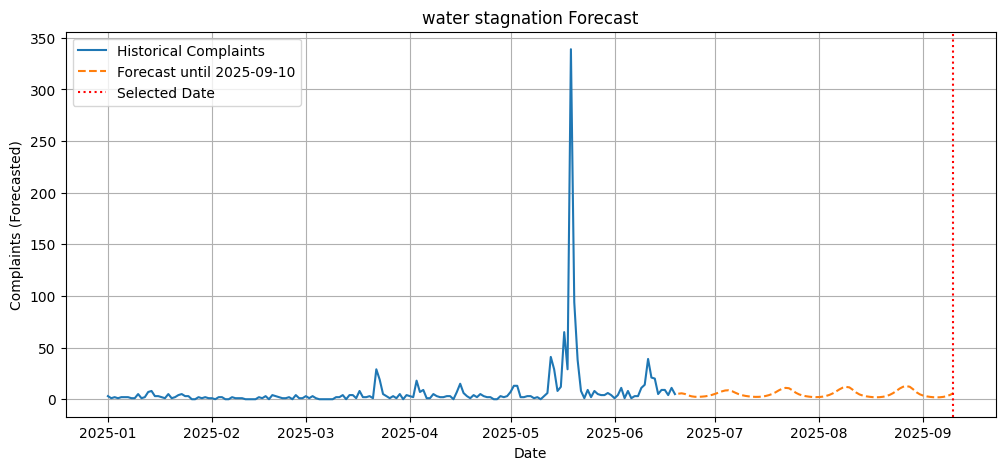

📅 Prediction for 2025-09-10 (water stagnation): 5.91


In [ ]:
def on_predict_click(b):
    clear_output(wait=True)
    display(ui)
    issue_forecast(category_dropdown.value, date_picker.value)

predict_button.on_click(on_predict_click)
display(ui)